**Crude Oil Price Forecasting**

**Data sources:**

**Overview**

The data is extracted at a day level, this is fed as a weighted average
of volume. Data timeline is from 2011 to current date indicating a
complex dataset

Machine learning model is built for crude price forecasting for the next
7 days based on the streaming and batch datasets in GCP.

Our main API was (St. Louis Fed's FRED API) for the below indicators.

**Commodity Prices**

We chose to include series that represent the oil market

DCOILWTICO: West Texas Intermediate (WTI) - Cushing Oklahoma

**Debt Market Indicators**

A ladder of bond market indicators are represented in the data in LIBOR
rates at various maturities. Specifically, LIBOR is included at
overnight, 1-month, 3-month and 12-month maturities. To (very crudely)
represent the consumer and the corporate markets we also included
indices representing high yield returns and prime corporate debt
returns.

**Energy-Related Series**

To confirm the presence of signals in the energy sector data, we collect
information on natural gas and energy sector volatility. This data is
obtained from the St. Louis Fed's FRED API.

MHHNGSP: Henry Hub Natural Gas Spot Price

VXXLECLS: [CBOE Energy Sector ETF Volatility
Index](https://fred.stlouisfed.org/series/VXXLECLS)

## Traditional Currencies

The CURRENCY DATABASE was accessed using archived data in Federal
Government database to gather currency exchange rates of the US Dollar
against the Japanese Yen, the Euro, the Chinese Yuan, the Mexican Peso,
and the Australian Dollar and their past trends.

-   DEXCHUS: [Chinese Yuan to
    USD](https://fred.stlouisfed.org/series/DEXCHUS)

-   DEXJPUS: [Japanese Yen to
    USD](https://fred.stlouisfed.org/series/DEXJPUS)

-   DEXUSEU: [USD to European Union's
    Euro](https://fred.stlouisfed.org/series/DEXUSEU)

-   DEXMXUS: [Mexican New Pesos to
    USD](https://fred.stlouisfed.org/series/DEXMXUS)

-   DEXUSAL: [USD to Australian
    Dollar](https://fred.stlouisfed.org/series/DEXUSAL)

Data pre-processing:

## Generating in Calendar Attributes for Merge

To ensure adjustment for temporal factors a
function generate_calendar is specified and used to merge in calendar
attributes to the data. These attributes, such as month or weekday, can
be used in a machine learning model alongside the data gathered from the
FRED API

**import** numpy **as** np

**def** generate_calendar(year, drop_index**=False**):

'''

Simple function to generate a calendar containing

US holidays, weekdays and holiday weeks.

'''

**from** pandas.tseries.offsets **import** YearEnd

**from** pandas.tseries.holiday **import** USFederalHolidayCalendar

start_date **=** pd**.**to_datetime('1/1/'**+**str(year))

end_date **=** start_date **+** YearEnd()

DAT **=** pd**.**date_range(str(start_date), str(end_date),
freq**=**'D')

MO **=** \[d**.**strftime('%B') **for** d **in** DAT\]

holidays **=**
USFederalHolidayCalendar()**.**holidays(start**=**start_date,
end**=**end_date)

cal_df **=** pd**.**DataFrame({'date':DAT, 'month':MO})

cal_df\['year'\] **=** \[format(d, '%Y') **for** d **in** DAT\]

cal_df\['weekday'\] **=** \[format(d, '%A') **for** d **in** DAT\]

cal_df\['is_weekday'\] **=**
cal_df**.**weekday**.**isin(\['Monday','Tuesday','Wednesday','Thursday','Friday'\])

cal_df\['is_weekday'\] **=** cal_df\['is_weekday'\]**.**astype(int)

cal_df\['is_holiday'\] **=** cal_df\['date'\]**.**isin(holidays)

cal_df\['is_holiday'\] **=** cal_df\['is_holiday'\]**.**astype(int)

cal_df\['is_holiday_week'\] **=**
cal_df**.**is_holiday**.**rolling(window**=**7,center**=True**,min_periods**=**1)**.**sum()

cal_df\['is_holiday_week'\] **=**
cal_df\['is_holiday_week'\]**.**astype(int)

**if** **not** drop_index: cal_df**.**set_index('date',
inplace**=True**)

**return** cal_df

**def** make_calendars(year_list, drop_index):

cal_df **=** pd**.**DataFrame()

**for** year **in** year_list:

cal_df **=** cal_df**.**append(generate_calendar(year,
drop_index**=**drop_index))

**return** cal_df

year_list **=** \[str(int(i)) **for** i **in** np**.**arange(2011,
2019)\]

cal_df **=** make_calendars(year_list, drop_index**=False**)

cal_df**.**head()

Output:

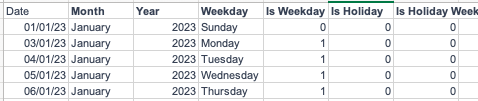

**Integrating Calendar Data and Handling Missing Values:**

When we incorporate calendar details for each day starting from 2011
through an outer join process, it naturally leads to the emergence of
missing values. This is typical in financial markets, particularly for
indicators like DJIA, where we see NaN values on weekends and holidays,
and for other metrics that aren't recorded daily. To address this, we
employ the pd.DataFrame.fillna function from Pandas in a two-step
process. Firstly, we apply the 'bfill' method, followed by the 'ffill'
method. This approach is chosen for its simplicity and to steer clear of
more intricate data imputation techniques, even though it might not be
the most scientifically rigorous method.

econ_df = econ_df.join(cal_df, how='outer')

econ_df = econ_df.fillna(method='bfill')

econ_df = econ_df.fillna(method='ffill')

**Eliminating Records Beyond Current Date**

Using Python's datetime module, we filter out any records in the dataset
that fall beyond the current date. This step is crucial as the calendar
function may have introduced future dates which aren't relevant for our
analysis.

**from datetime import datetime as dt**

**\# Remove records that are dated after the current date**

**current_date_filter = pd.to_datetime(econ_df.index.values) \<=
dt.now()**

**econ_df = econ_df.loc\[current_date_filter\]**

**Generating One-Hot Encoded Features:**

For the 'month', 'year', and 'weekday' columns in our dataset to be
effectively used in neural network models, they need to be transformed
into one-hot encoded vectors. This is achieved using the
**pd.get_dummies** function in Pandas, which converts these categorical
columns into a format suitable for machine learning models.

\# Implement one-hot encoding for specific columns

econ_df = pd.get_dummies(econ_df,

columns=\['month', 'year', 'weekday'\],

drop_first=True)

**Transforming Column Names to Lowercase:**

To maintain consistency and ease of access in our data handling, we'll
convert all column names in the econ_df DataFrame to lowercase. This is
a simple yet effective practice in data preprocessing, especially for
ensuring uniformity in column references.

\# Convert all column names in econ_df to lowercase

econ_df.columns = \[column_name.lower() for column_name in
econ_df.columns\]

print(econ_df.columns.tolist())

The resulting column names will be:

\['sp500', 'nasdaqcom', 'djia', 'ru2000pr', 'bogmbasew', 'dexjpus',
'dexuseu', 'dexchus', 'dexusal', 'vixcls', 'usdontd156n', 'usd1mtd156n',
'usd3mtd156n', 'usd12md156n', 'bamlhyh0a0hym2triv', 'bamlcc0a1aaatriv',
'goldamgbd228nlbm', 'dcoilwtico', 'mhhngsp', 'vxxlecls', 'is_weekday',
'is_holiday', 'is_holiday_week', 'month_august', 'month_december',
'month_february', 'month_january', 'month_july', 'month_june',
'month_march', 'month_may', 'month_november', 'month_october',
'month_september', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
'year_2016', 'year_2017', 'year_2018', 'weekday_monday',
'weekday_saturday', 'weekday_sunday', 'weekday_thursday',
'weekday_tuesday', 'weekday_wednesday'\].

**Enhancing Data Signal and Reducing Noise through Feature Engineering**

Our approach to refining the data involves two key steps aimed at
minimizing noise and amplifying the signal over time. Instead of working
directly with raw price data, we proceed as follows:

Data Transformation: We reshape the data to consist of just three
columns: 'date', 'variable', and 'value'. This is achieved by melting
the dataset.

Signal Processing: We then apply a method known as split-apply-combine.
This involves grouping the data by 'variable', computing the percent
change, and then calculating a rolling window mean of this percent
change.

Data Restoration: Finally, we spread the data back to its original
structure, substituting the raw values with the newly calculated rolling
window percent changes.

This methodology is designed to be more responsive to market
fluctuations rather than focusing on absolute values at any given point
in time. By taking a rolling mean, we also dilute any outlier market
movements, making them more representative of general trends.

Melting the econ_df DataFrame on the 'date' Column

To facilitate the split-apply-combine operation and streamline plotting,
we first melt econ_df on the 'date' column:

econ_df_melt = econ_df.copy()

econ_df_melt.reset_index(inplace=True)

econ_df_melt.rename(columns={'index': 'date'}, inplace=True)

econ_df_melt = econ_df_melt.melt(id_vars=\['date'\])

print(econ_df_melt.head())

This code snippet reshapes econ_df such that it only has three columns:
'date', 'variable', and 'value'. The first few rows of the transformed
DataFrame would look like this:

date variable value

2023-01-01 sp500 1271.87

2023-01-02 sp500 1271.87

2023-01-03 sp500 1271.87

2023-01-04 sp500 1270.20

2023-01-05 sp500 1276.56

This transformation sets the stage for the subsequent steps of feature
engineering to enhance the utility of the dataset for analytical
purposes.

Implementing the Split-Apply-Combine Process for Feature Calculation

To extract more meaningful insights from our econ_df_melt dataset, we
will implement a split-apply-combine strategy. This involves dividing
the dataset based on the 'variable' column, applying calculations to
each subset, and then recombining them. Notably, binary columns listed
in onehot_cols will not undergo this process as they don't require the
same transformation.

onehot_cols = \[

'is_weekday', 'is_holiday', 'is_holiday_week',

'month_august', 'month_december', 'month_february',

'month_january', 'month_july', 'month_june', 'month_march',

'month_may', 'month_november', 'month_october', 'month_september',

'year_2011', 'year_2012', 'year_2013', 'year_2014',

'year_2015', 'year_2016', 'year_2017', 'year_2018',

'weekday_monday', 'weekday_saturday', 'weekday_sunday',

'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday'

\]

We then specify a rolling window size and apply the transformation:

window = 30 \# Define the rolling window size

smooth_df = pd.DataFrame()

\# Perform split-apply-combine on the 'variable' column

for variable, group_df in econ_df_melt.groupby('variable'):

if variable not in onehot_cols:

group_df\['pct_change'\] = group_df\['value'\].pct_change() \# Calculate
percent change

colname = 'rolling\_' + str(window) + '\_mean'

group_df\[colname\] =
group_df\['pct_change'\].rolling(window=window).mean() \# Calculate
rolling mean

else:

group_df\[colname\] = group_df\['value'\] \# Keep onehot columns
unchanged

smooth_df = smooth_df.append(group_df) \# Append the processed data to
smooth_df

print(smooth_df.head())

In this code, we iterate through each group of data determined by unique
'variable' values. For non-binary columns, we compute the percent change
and then a rolling window mean. Binary columns are appended as is. This
refined dataset, smooth_df, now includes features that are more
indicative of trends and patterns over time, enhancing its potential
usefulness in modeling and analysis

| **Index** | **Date**   | **pct_change** | **rolling_30_mean** | **value** | **variable**    |
|-----------|------------|----------------|---------------------|-----------|-----------------|
| 44927     | 2023-01-01 | NaN            | NaN                 | 479.31    | bamlc0a1aaatriv |
| 44928     | 2023-01-02 | 0.00000        | NaN                 | 479.31    | bamlc0a1aaatriv |
| 44929     | 2023-01-03 | 0.00000        | NaN                 | 479.31    | bamlc0a1aaatriv |
| 44930     | 2023-01-04 | -0.000542      | NaN                 | 479.05    | bamlc0a1aaatriv |
| 44931     | 2023-01-05 | -0.007348      | NaN                 | 475.53    | bamlc0a1aaatriv |

Data Visualization and Restoration to Original Structure

The data visualization involved creating time-series plots for each
continuous feature, accompanied by an inverted histogram on the right
side of each plot to examine the distribution of percent changes over a
given window period.

import matplotlib.pyplot as plt

from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

%matplotlib inline

\# Setting locators and formatter for dates

yearly_locator = YearLocator()

monthly_locator = MonthLocator()

yearly_formatter = DateFormatter('%Y')

def visualize_data_with_histograms(dataframe, date_column,
series_column,

group_column, prepend_title='{}', labels=None,

rotate_x=0, pad_x\_label=60, rolling_window=15,

columns_to_exclude=\[\]):

'''

This function plots a time series and its rolling average, including a
histogram

to the right side of the time series plot.

Parameters:

dataframe: DataFrame containing the time series data

date_column: Column name for datetime data

series_column: Column name for the time series data

group_column: Column name for grouping the plots

labels: Dictionary containing labels for x and y axes

prepend_title: String to prepend to the title of each subplot

rotate_x: Degrees to rotate x-axis labels

pad_x\_label: Padding for the x-axis label

rolling_window: Window size for the rolling average

columns_to_exclude: List of column names to exclude from plotting

'''

unique_groups = dataframe\[group_column\].unique()

num_rows = len(unique_groups) - len(columns_to_exclude)

plot_size = (13, 6 \* num_rows)

fig, axis_set = plt.subplots(num_rows, 1, figsize=plot_size)

prepend_title_hist = 'Histogram of ' + prepend_title

counter = 0

for idx, group_value in enumerate(unique_groups):

subset_df = dataframe\[dataframe\[group_column\] == group_value\]

if group_value not in columns_to_exclude:

current_axis = axis_set\[counter\]

current_axis.plot(subset_df\[date_column\], subset_df\[series_column\],
alpha=0.2, color='black')

\# Plot rolling averages with different windows

for multiple in \[1, 3\]:

roll_window = rolling_window \* multiple

subset_df\[f'rolling\_{roll_window}\_avg'\] =
subset_df\[series_column\].rolling(window=roll_window,
min_periods=min(5, roll_window)).mean()

current_axis.plot(subset_df\[date_column\],
subset_df\[f'rolling\_{roll_window}\_avg'\], label=f'{roll_window}
period rolling avg')

\# Statistical lines

mean = subset_df\[series_column\].mean()

std_dev = subset_df\[series_column\].std()

for sigma_multiplier in \[-1, 0, 1\]:

current_axis.axhline(mean + sigma_multiplier\*std_dev, linestyle='--',
color='red' if sigma_multiplier == 0 else 'yellow', alpha=0.3)

current_axis.set_title(prepend_title.format(group_value))

current_axis.legend(loc='best')

current_axis.set_ylim(mean - 3\*std_dev, mean + 3\*std_dev)

if labels:

current_axis.set_xlabel(labels\['x_label'\])

current_axis.set_ylabel(labels\['y_label'\])

current_axis.xaxis.set_minor_locator(monthly_locator)

current_axis.grid(alpha=0.1)

if rotate_x != 0:

plt.setp(current_axis.get_xticklabels(), rotation=rotate_x)

\# Histogram on the right

divider = make_axes_locatable(current_axis)

right_axis = divider.append_axes('right', 1.2, pad=0.1,
sharey=current_axis)

right_axis.grid

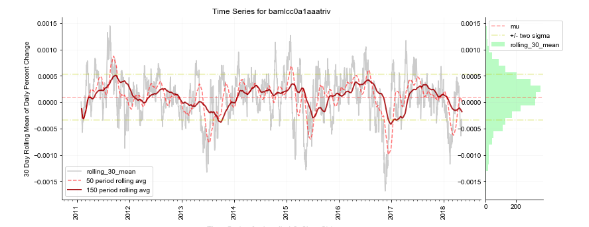

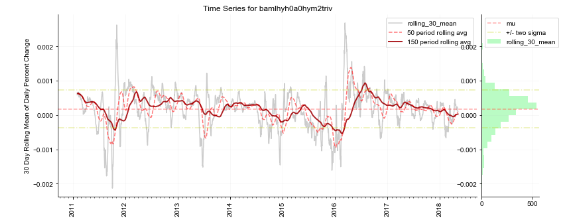

Sample time series plots above

Data reshaping:

To revert the data to its original wide format, used for the
visualization, we execute a pivot operation. This reshaping is vital for
our analyses that rely on the original structure of the data.

\# Pivot the melted dataframe to restore original wide format with new
features

reshaped_df = smooth_df.pivot(index='date', columns='variable',
values='rolling_30_mean')

reshaped_df.dropna(inplace=True)

\# Display the first few records of the reshaped dataframe

reshaped_df.head()

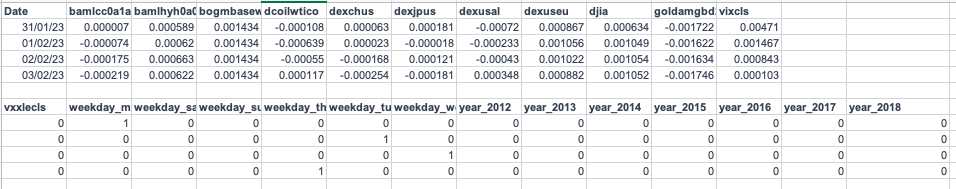

Visualize: Heatmap

To better understand the relationships between different financial
indicators, we create a scatterplot matrix for selected columns.
Additionally, we prepare the data for predicting the price of crude oil
by mapping actual prices to our smoothed dataset and splitting the data
for model training and evaluation.

Correlation Heatmap

The plot_correlation_heatmap function is designed to visualize the
correlation between the selected financial indicators. It calculates the
Pearson correlation coefficient between each pair of variables and then
plots a heatmap. This gives an immediate visual representation of how
strongly each pair of variables is related. The heatmap can be filtered
using a threshold parameter to only display correlations that are above
a certain absolute value, which helps in focusing on the most
significant relationships.

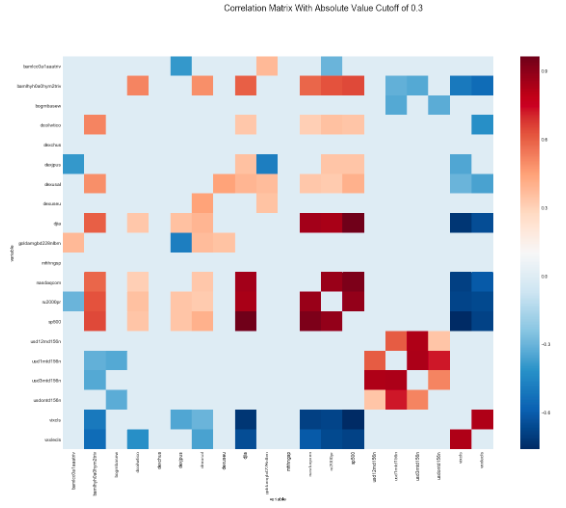

Data modelling for Predicting crude oil price

Preparing Data for the Prediction Model

Mapping Target Values

We map the actual prices of crude oil (dcoilwtico) to our dataset
(smooth_df). This is done by creating a dictionary from the econ_df and
mapping these values to the smooth_df based on the index, which
represents dates. This step is crucial to align our features with the
correct target variable that we aim to predict.

Shifting Target Values

Next, the target variable (dcoilwtico) is shifted backwards by a
specified window period. This is because we want to predict the future
value of crude oil based on current and past information. By shifting
the data, we ensure that the features correspond to the state of the
economy at the time of prediction, not at the time of the actual price.

Cleaning Up Data

We remove any rows that have NaN values resulting from the shifting
process with dropna. This ensures that our dataset does not have any
missing values which could lead to errors during the modeling process.

Data Export

The processed dataset is then saved to a CSV file for future use or
analysis. This is a common practice to ensure data integrity and to
provide checkpoints for long data processing workflows.

Splitting and Scaling Data

Data Splitting

We split our dataset into training and testing sets using the
train_test_split function from sklearn.model_selection. A portion of the
data (specified by train_size) is used to train the model, and the rest
is reserved for testing its performance.

Feature Scaling

The StandardScaler from sklearn.preprocessing is used to scale the
features. This is an important step in many machine learning algorithms
to standardize the range of independent variables or features of data.
It helps in speeding up the convergence of stochastic gradient descent
and other optimization algorithms.

Final Test Set Split

We further split the test set into a validation set and a final test
set. The validation set is used during the model training to fine-tune
model parameters and prevent overfitting. The final test set is kept
aside to evaluate the model's performance after training has concluded,
providing an unbiased assessment of the model's predictive power.

Visualizing Model Training

Plot Training and Validation Loss

The visualize_model_loss function is used to plot the training and
validation loss over each epoch during model training. This
visualization helps in diagnosing issues with the learning process, such
as overfitting or underfitting, and provides insights into the model's
convergence behavior.

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import pandas as pd

import numpy as np

%matplotlib inline

\# Define visualization columns

visualization_columns = \[

'bamlcc0a1aaatriv', 'bamlhyh0a0hym2triv', 'bogmbasew', 'dcoilwtico',

'dexchus', 'dexjpus', 'dexusal', 'dexuseu', 'djia', 'goldamgbd228nlbm',

'mhhngsp', 'nasdaqcom', 'ru2000pr', 'sp500', 'usd12md156n',
'usd1mtd156n',

'usd3mtd156n', 'usdontd156n', 'vixcls', 'vxxlecls'

\]

\# Function to plot correlation heatmap

def plot_correlation_heatmap(data_frame, threshold=None, plot_title=''):

corr_matrix = data_frame.corr(method='pearson')

np.fill_diagonal(corr_matrix.values, 0)

if threshold is not None:

corr_matrix = corr_matrix\[corr_matrix.abs() \> threshold\].fillna(0)

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)

plt.title(plot_title, fontsize=18)

plt.show()

return corr_matrix

\# Set cutoff for correlation and visualize heatmap

cutoff_threshold = 0.3

plot_correlation_heatmap(smooth_df\[visualization_columns\],
cutoff_threshold, 'Filtered Correlation Heatmap')

\# Prepare the data for predicting crude oil prices

target_column = 'dcoilwtico'

smooth_df\[target_column\] =
smooth_df.index.map(econ_df\[target_column\].to_dict())

smooth_df\[target_column\] =
smooth_df\[target_column\].shift(periods=-window)

smooth_df.dropna(inplace=True)

\# Export the processed data

filename = 'processed_data.csv'

smooth_df.to_csv(filename)

data\['processed_data'\] = smooth_df

\# Data splitting and scaling

def prepare_data_for_modeling(data_frame, features, target,
scale_columns=None, size=0.7):

X = data_frame\[features\]

y = data_frame\[target\]

X_train, X_test, y_train, y_test = train_test_split(X, y,
train_size=size)

scaler = StandardScaler()

if scale_columns:

X_train\[scale_columns\] =
scaler.fit_transform(X_train\[scale_columns\])

X_test\[scale_columns\] = scaler.transform(X_test\[scale_columns\])

return X_train, y_train, X_test, y_test

\# Identify columns to normalize and split the data

normalize_columns = \[col for col in smooth_df if col not in
onehot_cols + \[target_column\]\]

feature_columns = \[col for col in smooth_df if col != target_column\]

X_train, y_train, X_test, y_test = prepare_data_for_modeling(smooth_df,
feature_columns, target_column, normalize_columns)

\# Further split for final evaluation

test_cutoff = len(X_test) // 2

X_validation, y_validation = X_test\[:test_cutoff\],
y_test\[:test_cutoff\]

X_final_test, y_final_test = X_test\[test_cutoff:\],
y_test\[test_cutoff:\]

\# Define a function to plot model loss

def visualize_model_loss(history, plot_width=11):

training_loss = history\['loss'\]

validation_loss = history\['val_loss'\]

epochs = range(1, len(training_loss) + 1)

sns.set_style("white")

plt.figure(figsize=(plot_width, 6))

plt.plot(epochs, training_loss, 'g--', label='Training Loss')

plt.plot(epochs, validation_loss, 'b-.', label='Validation Loss')

plt.title('Training & Validation Loss Over Epochs')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

Conducting a Grid Search for Neural Network Hyperparameter Optimization

Defining the Model Generation Function

We begin by defining a function named create_nn_model that simplifies
the construction of a feedforward neural network with dense layers. This
function allows us to experiment with different hyperparameters like the
number of neurons per layer, the number of hidden layers, regularization
strength, dropout rate, and more. Although it's set up to use certain
defaults (like mean squared error for the loss and ReLU activation),
it's flexible enough to test variations in activation functions,
optimizers, and loss functions if desired.

Setting Up the Hyperparameter Space

We define a hyperparameter space by creating lists or ranges of possible
values for the number of neurons (neurons_range), the number of dense
layers (layers_range), dropout rates (dropout_options), and
regularization strengths (reg_values). These are the parameters over
which we will perform our grid search to find the best combination for
our predictive model.

Performing the Grid Search

Using nested loops, we iterate over every possible combination of
hyperparameters defined in our search space. For each combination, we:

Construct a new model with the create_nn_model function using the
current set of hyperparameters.

Set up an EarlyStopping callback with patience=1, which will halt
training if the validation loss doesn't improve, preventing unnecessary
computations and potential overfitting.

Train the model on the training data while monitoring the validation
loss.

Predict and evaluate the model's performance on the training,
validation, and test datasets, calculating the R-squared value for each.

Saving and Analyzing Results

Each model's performance metrics and configuration are stored in a
dictionary named results_summary. This enables post-analysis and
comparison between different models to select the best performing ones
based on the test R-squared values.

\# Pseudocode for illustrative purposes

import tensorflow as tf

from keras.models import Sequential

from keras.layers import Dense, Dropout

from keras.regularizers import l1_l2

from keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score

def create_nn_model(neurons, layers, reg_rate, dropout_rate):

model = Sequential()

\# Add input layer

model.add(Dense(neurons, activation='relu',
input_shape=(X_train.shape\[1\],),

kernel_regularizer=l1_l2(l1=reg_rate, l2=reg_rate)))

\# Add hidden layers

for \_ in range(layers):

model.add(Dense(neurons, activation='relu',

kernel_regularizer=l1_l2(l1=reg_rate, l2=reg_rate)))

model.add(Dropout(dropout_rate))

\# Add output layer

model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

return model

\# Hyperparameter ranges

dropout_options = \[0.0, 0.1, 0.2, 0.3\]

neurons_range = \[16, 22, 28, 34\]

layers_range = \[1, 2\]

reg_values = \[0.005, 0.001, 0.0005\]

results_summary = {}

\# Grid search

for neurons in neurons_range:

for layers in layers_range:

for dropout_rate in dropout_options:

for reg_rate in reg_values:

model = create_nn_model(neurons, layers, reg_rate, dropout_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(X_train, y_train, epochs=1000,
batch_size=X_train.shape\[0\] // 4,

verbose=0, validation_data=(X_val, y_val), callbacks=\[early_stopping\])

\# Generate model ID and store results

model_id = f"{neurons}\_{layers}\_{dropout_rate}\_{reg_rate}"

results_summary\[model_id\] = evaluate_model(model, X_train, y_train,
X_val, y_val, X_test, y_test)

\# Function to evaluate the model

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test,
y_test):

\# Make predictions

train_pred = model.predict(X_train)

val_pred = model.predict(X_val)

test_pred = model.predict(X_test)

\# Calculate R-squared for each set

train_r2 = r2_score(y_train, train_pred)

val_r2 = r2_score(y_val, val_pred)

test_r2 = r2_score(y_test, test_pred)

\# Continue the function to evaluate the model

return {

'train_r2': train_r2,

'val_r2': val_r2,

'test_r2': test_r2,

'history': history.history,

'neurons': neurons,

'layers': layers,

'dropout': dropout_rate,

'regularizer': reg_rate

}

\# Iterate over the results to print the performance

for model_id, metrics in results_summary.items():

print(f"Model ID: {model_id}")

print(f"Train R-squared: {metrics\['train_r2'\]:.4f}")

print(f"Validation R-squared: {metrics\['val_r2'\]:.4f}")

print(f"Test R-squared: {metrics\['test_r2'\]:.4f}")

print("-" \* 80)

\# Optionally, plot the loss curves for the best performing models

def plot_training_curves(history):

plt.figure(figsize=(10, 5))

plt.plot(history\['loss'\], label='Training Loss')

plt.plot(history\['val_loss'\], label='Validation Loss')

plt.title('Training vs Validation Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

\# Identify the best model based on validation R-squared

best_model_id = max(results_summary, key=lambda id:
results_summary\[id\]\['val_r2'\])

best_model_metrics = results_summary\[best_model_id\]

print(f"Best Model ID: {best_model_id}")

print(f"Best Model Validation R-squared:
{best_model_metrics\['val_r2'\]:.4f}")

\# Plotting the training and validation loss curves for the best model

plot_training_curves(best_model_metrics\['history'\])

Evaluate the Model

The evaluate_model function computes the R-squared metric for the
training, validation, and test predictions to assess the model's
performance. It returns a dictionary containing these metrics and the
history of the training process.

Print Model Performances

The script iterates over the results_summary dictionary, printing the
R-squared values for each model. This allows a quick review of how each
model performed.

Plot Training Curves

The plot_training_curves function is provided to visually examine the
training process of the models. It plots the loss across epochs for both
training and validation sets, which can indicate overfitting if the
validation loss increases while the training loss decreases.

Select the Best Model

The best model is determined by finding the model ID with the highest
validation R-squared in the results_summary. Identifying the best model
helps in understanding which combination of hyperparameters yields the
most promising results on unseen data.

Visualize the Best Model's Performance

Finally, the training and validation loss curves of the best model are
plotted. This visual assessment can help confirm the model's ability to
learn from the training data without overfitting to it.

Model \# 1

Fully Connected Model w/ Dropout & Regularization

\- Regularizer Rate: 0.0050000

\- Dropout Rate: 0.000

\- Number Dense Layers: 1

\- Neurons per Layer: 16

R-squared on training data = 0.8849

R-squared on validation data = 0.8662

R-squared on testing data = 0.8526

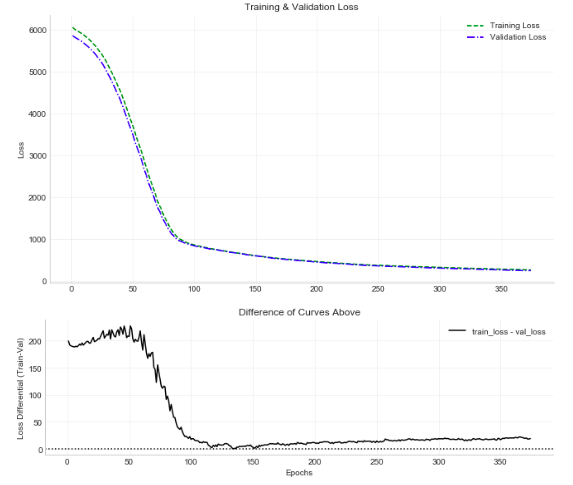

Model \# 2

Fully Connected Model w/ Dropout & Regularization

\- Regularizer Rate: 0.0010000

\- Dropout Rate: 0.000

\- Number Dense Layers: 1

\- Neurons per Layer: 16

R-squared on training data = 0.8797

R-squared on validation data = 0.8545

R-squared on testing data = 0.8506

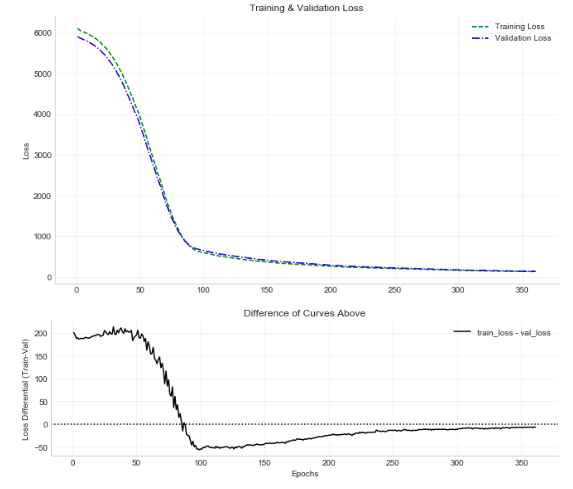

## Plot the Train, Test and Validation r2_score

Visualization and Analysis of Model Performance

Visualizing R-squared Values

We'll convert the R-squared values into floating-point numbers for
better precision during calculations. Then, we visualize the average
R-squared values for the training, validation, and test sets, grouped by
the number of neurons per layer. A horizontal bar chart is used for this
visualization, allowing us to compare how the number of units affects
the model's performance across different datasets.

\# Convert R-squared columns to float for precision

results_df\[r2_cols\] = results_df\[r2_cols\].astype(np.float32)

\# Group by the number of units and plot their average R-squared values

units_performance = results_df.groupby(\['neurons'\])\[r2_cols\].mean()

units_performance.plot(kind='barh', subplots=True, figsize=(10, 15),
color=\['#1f77b4', '#ff7f0e', '#2ca02c'\])

plt.tight_layout()

plt.show()

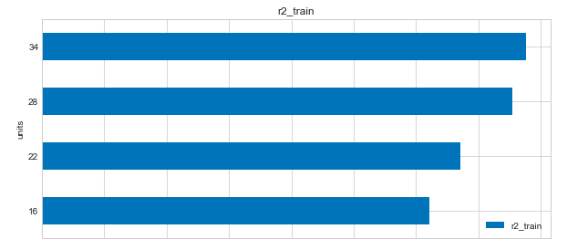

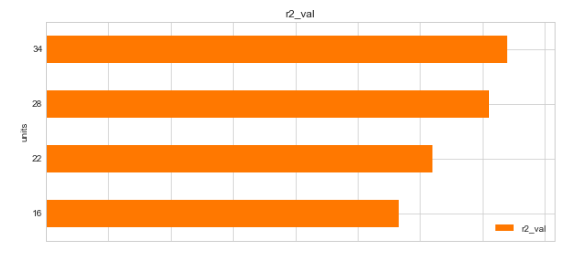

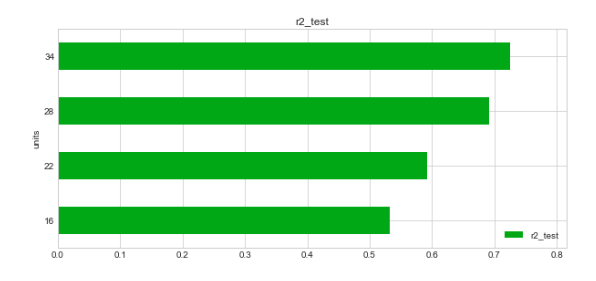

Selecting the Optimum Model

To find the model with the highest R-squared value on the test set, we
use the idxmax method. We then save this best-performing model to disk
for future use, ensuring that the hard work of training doesn't need to
be repeated.

\# Identify the index of the best model based on test R-squared

optimal_model_index = results_df\['r2_test'\].idxmax()

\# Save the best model to a file

optimal_model = models_archive\[optimal_model_index\]\['model'\]

optimal_model.save('optimal_model.h5')

\# Plot actual vs predicted values to assess model performance visually

predictions = optimal_model.predict(X_test)

plt.figure(figsize=(15, 7))

plt.scatter(y_test, predictions, edgecolors='k', alpha=0.7)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('Actual Values')

plt.ylabel('Predicted Values')

plt.title('Comparison of Actual and Predicted Values', fontsize=16)

sns.despine()

plt.show()

units 34

layers 2

dropout 0

regularizer 0.005

r2_train 0.956788

r2_val 0.938761

r2_test 0.945236

Examining the Best Model

We delve deeper into the architecture and performance of the best model
by plotting its training history and examining its summary.
Additionally, we review the specific record in our results dataframe
that corresponds to the best model to understand its configuration.

\# Plot the training history of the best model

optimal_model_history =
models_archive\[optimal_model_index\]\['history'\]

plot_training_history(optimal_model_history)

plt.savefig('optimal_model_training_history.png')

\# Print a summary of the best model to understand its structure

print("Best Model Summary:")

optimal_model.summary()

\# Display the best model's hyperparameters and performance metrics

optimal_model_info = results_df.loc\[optimal_model_index\]

print("Best Model Info:")

print(optimal_model_info)

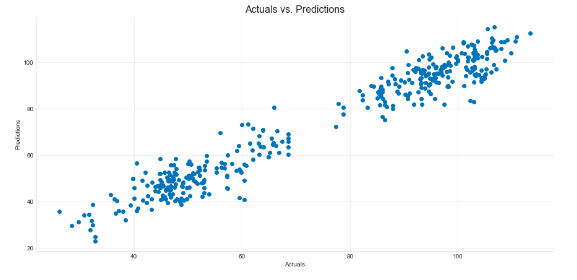

We see here that a model that uses 22 units per layer, two layers (note
that the first layer is not counted in the num_layers parameter), no
dropout and an l1/l2 regularizer of 0.005. The

score for all data sets is very high, which should give cause for
suspicion and further investigation.

Prediction Generation and Evaluation

Data Preprocessing Function

We define a function prepare_data_for_prediction that takes a DataFrame
and the names of the feature columns, target column, and any columns
that require normalization. This function standardizes the feature data,
aligning it with the preprocessing steps our model expects.

def prepare_data_for_prediction(data, feature_names, target_name,
columns_to_normalize=None):

\# Extract features and target

features = data\[feature_names\]

target = data\[target_name\]

\# Initialize standard scaler

scaler = StandardScaler()

\# Normalize features if specified

if columns_to_normalize:

features\[columns_to_normalize\] =
scaler.fit_transform(features\[columns_to_normalize\])

else:

features = pd.DataFrame(scaler.fit_transform(features),
columns=features.columns)

\# Return the prepared features and target

return features, target

\# Prepare the data for prediction

prepared_X, prepared_Y = prepare_data_for_prediction(smoothed_dataframe,
feature_columns, target_column, columns_to_normalize)

Visualization of Predictions

We generate predictions for the entire dataset using our optimal model
and visualize these predictions alongside the actual target values. We
also plot the errors to assess where the model's predictions diverge
from reality.

\# Generate predictions

predictions_array =
optimal_model.predict(prepared_X.to_numpy()).flatten()

predictions_series = pd.Series(predictions_array,
index=pd.to_datetime(prepared_X.index))

\# Create a DataFrame to compare predictions with actuals

comparison_df = pd.DataFrame({'predicted': predictions_series, 'actual':
prepared_Y}).dropna()

\# Plotting the predictions and actuals

plt.figure(figsize=(15, 7))

plt.plot(comparison_df.index, comparison_df\['predicted'\],
label='Predicted', linestyle=':', color='green', alpha=0.9)

plt.plot(comparison_df.index, comparison_df\['actual'\], label='Actual',
color='black', alpha=0.7, linewidth=0.5)

plt.xlabel('Date')

plt.ylabel('Crude Oil Price')

plt.title('Comparison of Predicted and Actual Crude Oil Prices',
fontsize=16)

plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

sns.despine()

plt.show()

\# Plotting the prediction errors

plt.figure(figsize=(15, 3))

prediction_errors = comparison_df\['predicted'\] -
comparison_df\['actual'\]

plt.plot(comparison_df.index, prediction_errors, label='Prediction
Error', linestyle='--', color='red', alpha=0.5)

plt.xlabel('Date')

plt.ylabel('Prediction Error')

plt.title('Prediction Errors Over Time', fontsize=16)

plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

sns.despine()

plt.show()

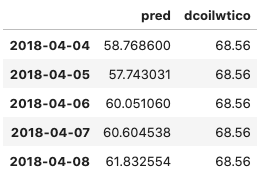

\# Calculating and printing the R-squared value for the final
predictions

final_r2_score = r2_score(comparison_df\['actual'\],
comparison_df\['predicted'\])

print(f"R-squared for the entire data

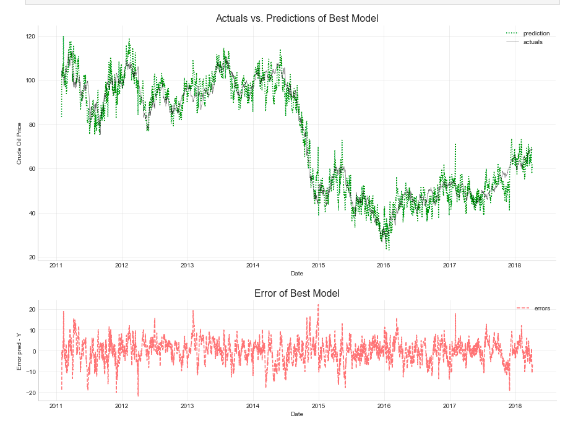

R-squared on entire dataset: 0.9540